# Experimenting with MODIS and PACE data compared to OCx algorithm

In [1]:
1 

1

In [1]:
import scipy.io

import earthaccess
import xarray as xr
from xarray.backends.api import open_datatree
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt
from netCDF4 import Dataset


from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

In [3]:
plt.rcParams.update({'font.size': 18})

In [4]:
auth = earthaccess.login(persist=True)

## Grab MODIS data

In [5]:
tspan = ("2024-07-01", "2024-07-01") # summer image
# tspan = ("2020-01-01", "2020-01-01") # winter image
# tspan = ("2025-01-15", "2025-01-15") # image for unique pix comparison

results = earthaccess.search_data(
    short_name="MODISA_L3m_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

Grabbing the specific URLs we want from this list

In [6]:
modis_fns = []
for i in range(int(len(results))):
    item = results[i]['umm']['RelatedUrls'][1]['URL']
    if 'DAY' in item:
        if '4km' in item:
            if 'Rrs_' in item:
                modis_fns.append(item)
            print(item)

https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_412.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.angstrom.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_469.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_443.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_531.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_678.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_667.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_645.4km.nc
https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.R

In [7]:
modis_fns

['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_412.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_469.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_443.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_531.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_678.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_667.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_645.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_555.4km.nc',
 'https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-pub

In [8]:
ls data/

AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_443.4km.nc
AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_488.4km.nc
AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_555.4km.nc
insitudb_chla_V3.tab
insitudb_rrs_satbands6_V3.tab
insitudb_rrs_V3.tab
PACE_OCI.20240609_20240710.L3m.R32.RRS.V3_1.Rrs.4km.nc
pace_with_hull.nc
Time_Varying_Biomes.nc
valente_chla_rrs_v3.csv


In [9]:
# modis_global = xr.open_mfdataset(modis_fns)

modis_fns = [
'data/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_443.4km.nc',
'data/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_488.4km.nc',
'data/AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_555.4km.nc'
]

modis_global = xr.open_mfdataset(modis_fns)

In [10]:
modis_global.load()

<xarray.Dataset> Size: 448MB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs_443  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
    palette  (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 111 ... 0 0 0 0 0
    Rrs_488  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
    Rrs_555  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/64)
    product_name:                      AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_44...
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    source:                            satellite observations from MODIS-Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/RRS/2022
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3087656
    data_minimum:                      -0.0009199977
    data_maximum:                      0.031985004

In [11]:
modis_global.Rrs_443.nbytes / 1e9

0.1492992

# open PACE

In [12]:
tspan = ("2024-07-01", "2024-07-01")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

In [13]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
pace_fns = []
for i in range(len(paths)):
    if 'DAY' in str(paths[i]):
        # if 'p1deg' in str(paths[i]):
        if '4km' in str(paths[i]):
            print(i)
            pace_fns.append(paths[i])
pace_fns

13


[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240701.L3m.DAY.RRS.V3_1.Rrs.4km.nc>]

In [17]:
paths = earthaccess.download(results[13], local_path="data_tmp")
print('file downloaded')
pace_global = xr.open_dataset(paths[0])

file downloaded


In [18]:
pace_global

<xarray.Dataset> Size: 26GB
Dimensions:     (wavelength: 172, lat: 4320, lon: 8640, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3471992
    data_minimum:                      -0.009997999
    data_maximum:                      0.055

In [45]:
# pace_global = xr.open_dataset(pace_fns[0])

In [46]:
# results[3]

In [29]:
# paths = earthaccess.download(results[3], local_path="data")

In [30]:
paths

[PosixPath('data/PACE_OCI.20240609_20240710.L3m.R32.RRS.V3_1.Rrs.4km.nc')]

In [47]:
# pace_global = xr.open_mfdataset(paths)

In [48]:
pace_global

<xarray.Dataset> Size: 26GB
Dimensions:     (wavelength: 172, lat: 4320, lon: 8640, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3471992
    data_minimum:                      -0.009997999
    data_maximum:                      0.055

## grab the data from Valente

In [2]:
chla_df = pd.read_csv('data/insitudb_chla_V3.tab',skiprows=28, delimiter='\t')

chla_df = chla_df.set_index('ID (idx)')

In [3]:
# rrs_df = pd.read_csv('data/insitudb_rrs_V3.tab',skiprows=969, delimiter='\t')

# rrs_df = rrs_df.set_index('ID (idx)')

In [4]:
rrs_df = pd.read_csv('data/insitudb_rrs_satbands6_V3.tab',skiprows=159, delimiter='\t')

rrs_df = rrs_df.set_index('ID (idx)')

In [5]:
rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0)

Lambda [nm] (assigned to MOD1)    412.4
Lambda [nm] (assigned to MOD2)    442.1
Lambda [nm] (assigned to MOD3)    490.0
Lambda [nm] (assigned to MOD4)    530.6
Lambda [nm] (assigned to MOD5)    551.1
Lambda [nm] (assigned to MOD6)    667.7
Lambda [nm] (assigned to MOD7)    681.0
Lambda [nm] (assigned to MOD8)    748.0
Lambda [nm] (assigned to MOD9)    869.9
dtype: float64

In [6]:
wls = np.array([412.4, 442.1, 490. , 510, 555, 667.7, 681. , 748. , 869.9])

In [7]:
# wavelengths = [float(wl_str[15:-3]) for wl_str in rrs_df.columns[3:-4]]

In [8]:
# rrs_df.columns = list(rrs_df.columns[:3])+ wavelengths + list(rrs_df.columns[-4:])

In [9]:
# valente_df = pd.merge(rrs_df,chla_df)

In [10]:
# find the column closest to the intended wl that is nonnan with a tolerance of 10nm

In [11]:
# indices = []
# for w in wls:
#     indices.append(np.argmin(abs(wavelengths-w)))

In [12]:
# wl_cols = [wavelengths[i] for i in indices]

In [13]:
# valente_df.iloc[:,188-20:188+20]

In [14]:
# means = []
# for i in indices:
#     means.append(valente_df.iloc[:,i-20:i+20].mean(axis=1))

In [15]:
# valente_reduced = pd.DataFrame(np.array(means).T, columns=wls)

# now with the premade subset

In [16]:
rrs_subset = rrs_df.iloc[:,np.arange(27,45,2)]

In [17]:
rrs_subset.columns = rrs_df.iloc[:,np.arange(28,46,2)].median(axis=0).values

In [18]:
rrs_subset

412.4     442.1     490.0     530.6     551.1     667.7  \
ID (idx)                                                               
1         0.005377  0.004674  0.005059       NaN       NaN  0.000432   
20        0.004338  0.003396  0.003545       NaN       NaN  0.000222   
23        0.004308  0.003106  0.003106       NaN       NaN  0.000204   
24        0.011927  0.011094  0.010550       NaN       NaN  0.002419   
67        0.006443  0.005456  0.004668       NaN       NaN  0.000139   
...            ...       ...       ...       ...       ...       ...   
151669    0.010823  0.008112  0.005474  0.001950  0.001449  0.000077   
151670    0.010144  0.007727  0.005283  0.001891  0.001405  0.000077   
151671    0.011223  0.008521  0.005673  0.001982  0.001473  0.000083   
151672    0.010234  0.007817  0.005328  0.001906  0.001418  0.000079   
151673    0.010559  0.008049  0.005471  0.001957  0.001456  0.000077   

             681.0  748.0  869.9  
ID (idx)                          
1              NaN    NaN    NaN  
20             NaN    NaN    NaN  
23             NaN    NaN    NaN  
24             NaN    NaN    NaN  
67        0.000231    NaN    NaN  
...            ...    ...    ...  
151669    0.000072    NaN    NaN  
151670    0.000071    NaN    NaN  
151671    0.000077    NaN    NaN  
151672    0.000075    NaN    NaN  
151673    0.000071    NaN    NaN  

[68641 rows x 9 columns]

In [19]:
# trying now with the original 6 wv dataset from MODIS
valente_df = pd.merge(rrs_subset,chla_df, right_index=True, left_index=True)

In [20]:
valente_reduced = valente_df

In [21]:
# valente_reduced['HPLC'] = valente_df['Chl a [mg/m**3] (High Performance Liquid Chrom...)']
# valente_reduced['flur'] = valente_df['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)']
valente_reduced['Latitude'] = valente_df['Latitude']
valente_reduced['Longitude'] = valente_df['Longitude']

In [22]:
valente_reduced['chla'] = valente_reduced['Chl a [mg/m**3] (High Performance Liquid Chrom...)'].fillna(valente_reduced['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)'])

In [23]:
# valente_reduced.to_csv('data/valente_chla_rrs_v3.csv')

In [24]:
gdf = gpd.GeoDataFrame(
    valente_reduced, geometry=gpd.points_from_xy(valente_reduced.Longitude, valente_reduced.Latitude), crs="EPSG:4326"
)

In [25]:
# valente_reduced['HPLC'] = valente_df['Chl a [mg/m**3] (High Performance Liquid Chrom...)']
# valente_reduced['flur'] = valente_df['Chl a [mg/m**3] (Chlorophyll a, fluorometric o...)']

In [26]:
# fig, ax = plt.subplots(figsize=(5,5))

# ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[551.1], 
#            y = valente_reduced.flur,)#c=np.nanargmax([valente_reduced[442.1],valente_reduced[490.0],valente_reduced[510]],axis=0), cmap='Set1')

# ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[551.1], 
#            y = valente_reduced.HPLC,)

# ax.set_xscale('log',base=3.333)
# ax.set_yscale('log')

# ax.set_ylabel('chla')
# ax.set_xlabel('MBR')

# ax.set_ylim(0.01,100)
# ax.set_xlim(0.3,20)

# plt.show()

In [27]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# this was the original distance approach in 2D
x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0)
y = valente_df[551.1].values
pts = np.array([x,y])
pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# the 3D approach
# pts = np.array([valente_df[442.1],valente_df[490.0],valente_df[551.1]])
# pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  # return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    return(np.linalg.norm(a-b))

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist = d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.3]

/tmp/ipykernel_148/4175504232.py:17: RuntimeWarning: All-NaN axis encountered
  x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0)


array([0.31491375, 0.81345096, 1.28377256, 3.48624781])

(1014, 2)

In [37]:
len(pts[dist_ratio > 0.2])

10

In [32]:
dist_ratio[dist_ratio > 0.3]

array([0.31491375, 0.81345096, 1.28377256, 3.48624781])

In [45]:
modis_global

<xarray.Dataset> Size: 448MB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs_443  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
    palette  (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 111 ... 0 0 0 0 0
    Rrs_488  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
    Rrs_555  (lat, lon) float32 149MB nan nan nan nan nan ... nan nan nan nan
Attributes: (12/64)
    product_name:                      AQUA_MODIS.20240701.L3m.DAY.RRS.Rrs_44...
    instrument:                        MODIS
    title:                             MODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    source:                            satellite observations from MODIS-Aqua
    ...                                ...
    identifier_product_doi:            10.5067/AQUA/MODIS/L3M/RRS/2022
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3087656
    data_minimum:                      -0.0009199977
    data_maximum:                      0.031985004

In [46]:
4320*8640

37324800

In [51]:
# ds = pace_global
ds = modis_global

from scipy.spatial import Delaunay

native_ids = [] 
inside = []
outside = []
valid_pixel_count = []

count_map = np.zeros([4320,8640])
nonnan_map = np.zeros([4320,8640])

count_map_ndims = []
nonnan_map_ndims = []

hull =  Delaunay(pts[dist_ratio < 0.2])

# PACE
# pace_pts = np.array([np.max([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten()],axis=0),ds.Rrs[:,:,84].values.flatten()]).T

# MODIS
pace_pts = np.array([np.max([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), 
                    modis_global.Rrs_555.values.flatten()]).T

print('data formatted')

bool_mask = (~np.isnan(pace_pts)).all(axis=1)

valid_pixel_count.append(np.count_nonzero(bool_mask))

points_in_hull = np.zeros(37324800, dtype=bool)
points_in_hull[bool_mask] = hull.find_simplex(pace_pts[bool_mask])>=0
print('hull analysis done')

# for PACE
# count_map += points_in_hull.reshape(ds.Rrs.shape[:2])
# count_map_ndims.append(points_in_hull.reshape(ds.Rrs.shape[:2]))
# nonnan_map_ndims.append((~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2]))
# nonnan_map += (~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2])

# for MODIS
count_map += points_in_hull.reshape(ds.Rrs_443.shape[:2])
count_map_ndims.append(points_in_hull.reshape(ds.Rrs_443.shape[:2]))
nonnan_map_ndims.append((~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs_443.shape[:2]))
nonnan_map += (~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs_443.shape[:2])

boolie, count = np.unique(points_in_hull[(~np.isnan(pace_pts)).all(axis=1)],return_counts=True)
if boolie[0]:
    in_count = count[0]
    out_count = count[1]
else:
    in_count = count[1]
    out_count = count[0]
inside.append(in_count)
outside.append(out_count)

data formatted
hull analysis done


In [48]:
# PACE

In [49]:
1-np.nanmean((count_map/nonnan_map).flatten())

/tmp/ipykernel_519/784881.py:1: RuntimeWarning: invalid value encountered in divide
  1-np.nanmean((count_map/nonnan_map).flatten())


0.11088965642777981

In [52]:
# MODIS

In [53]:
1-np.nanmean((count_map/nonnan_map).flatten())

/tmp/ipykernel_519/784881.py:1: RuntimeWarning: invalid value encountered in divide
  1-np.nanmean((count_map/nonnan_map).flatten())


0.3287108408449646

In [54]:
np.nanmin(pace_global.Rrs[:,:,42].values.flatten())

-0.0011979975

In [55]:
np.nanmin(pace_global.Rrs[:,:,60].values.flatten())

-0.0043979995

In [56]:
np.nanmin(pace_global.Rrs[:,:,84].values.flatten())

0.00049600005

In [66]:
pace_pts.shape

(37324800, 2)

/tmp/ipykernel_519/1362988396.py:29: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


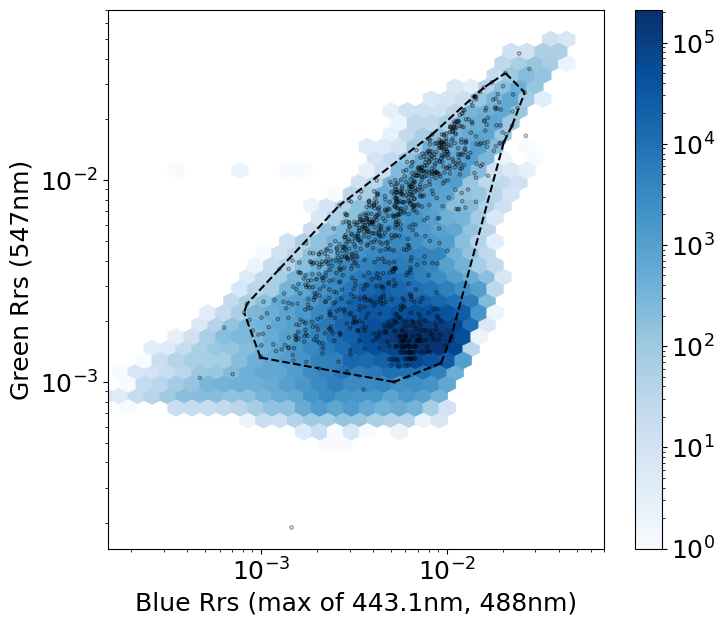

In [68]:
skip_num = 1

fig, ax = plt.subplots(figsize=(8,7))


# for MODIS
# hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
#                        modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
#            y = modis_global.Rrs_555.values.flatten()[::skip_num],
#           yscale='log',xscale='log',
#          gridsize=30,
#           bins='log',
#          cmap='Blues')

# for PACE

pace_pts = np.array([np.max([pace_global.Rrs[:,:,42].values.flatten(),pace_global.Rrs[:,:,60].values.flatten()],axis=0),pace_global.Rrs[:,:,84].values.flatten()]).T
pace_pts[pace_pts < 0] = np.nan

hb = ax.hexbin(x = pace_pts[:,0], 
           y = pace_pts[:,1],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

# ax.set_title('MODIS and Valente 2024-07-01')

# plt.savefig('modis_summer_valente_density_2024.png',dpi=300)
plt.savefig('pace_summer_valente_density_2024.png',dpi=300)

plt.show()

In [ ]:
1

## make the figure of the distance metric

In [187]:
# tspan = ("2024-07-01", "2024-07-01")
tspan = ("2025-01-15", "2025-01-15")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

In [188]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/6 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/6 [00:00<?, ?it/s]

In [189]:
pace_fns = []
for i in range(len(paths)):
    print(paths[i])
    if 'DAY' in str(paths[i]):
        if '4km' in str(paths[i]):
        # if '4km' in str(paths[i]):
            pace_fns.append(paths[i])
            print(i)
pace_fns

<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250101_20250131.L3m.MO.RRS.V3_0.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250101_20250131.L3m.MO.RRS.V3_0.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250109_20250116.L3m.8D.RRS.V3_0.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250109_20250116.L3m.8D.RRS.V3_0.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250115.L3m.DAY.RRS.V3_0.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250115.L3m.DAY.RRS.V3_0.Rrs.4km.nc>
5


[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250115.L3m.DAY.RRS.V3_0.Rrs.4km.nc>]

In [190]:
paths = earthaccess.download(results[5], local_path="data")
pace_global = xr.open_mfdataset(paths)

In [235]:
pace_global.wavelength[[57, 83]]

<xarray.DataArray 'wavelength' (wavelength: 2)> Size: 16B
array([487., 553.])
Coordinates:
  * wavelength  (wavelength) float64 16B 487.0 553.0
Attributes:
    long_name:  wavelengths
    units:      nm
    valid_min:  0
    valid_max:  20000

In [236]:
pace_pts = np.array([pace_global.Rrs[:,:,57].values.flatten(),pace_global.Rrs[:,:,84].values.flatten()]).T

In [374]:
# modis_global = xr.open_mfdataset(modis_fns)

modis_fns = [
'data/AQUA_MODIS.20250115.L3m.DAY.RRS.Rrs_488.4km.nc',
'data/AQUA_MODIS.20250115.L3m.DAY.RRS.Rrs_555.4km.nc'
]

modis_global = xr.open_mfdataset(modis_fns)


pace_pts = np.array([modis_global.Rrs_488.values.flatten(), 
                    modis_global.Rrs_555.values.flatten()]).T

In [375]:
len(pace_pts)

37324800

In [376]:
uniques = np.zeros((2,5000))
count = 0

for pixel in pace_pts:
    if np.isnan(pixel).any():
        pass
    first_value =  abs(pixel[0] - uniques[0])/uniques[0] > 0.025
    second_value = abs(pixel[1] - uniques[1])/uniques[1] > 0.025

    different = first_value | second_value
    
    if different.all():
        uniques[0,count] = pixel[0]
        uniques[1,count] = pixel[1]
        count += 1

/tmp/ipykernel_135/196144508.py:7: RuntimeWarning: divide by zero encountered in divide
  first_value =  abs(pixel[0] - uniques[0])/uniques[0] > 0.025
/tmp/ipykernel_135/196144508.py:8: RuntimeWarning: divide by zero encountered in divide
  second_value = abs(pixel[1] - uniques[1])/uniques[1] > 0.025


IndexError: index 5000 is out of bounds for axis 1 with size 5000

In [ ]:
count

In [ ]:
(~np.isnan(pace_pts)).sum()

In [264]:
2163/6294438

0.000343636715462127

Text(0.5, 1.0, 'MODIS,L3,4km Jan 15 2025')

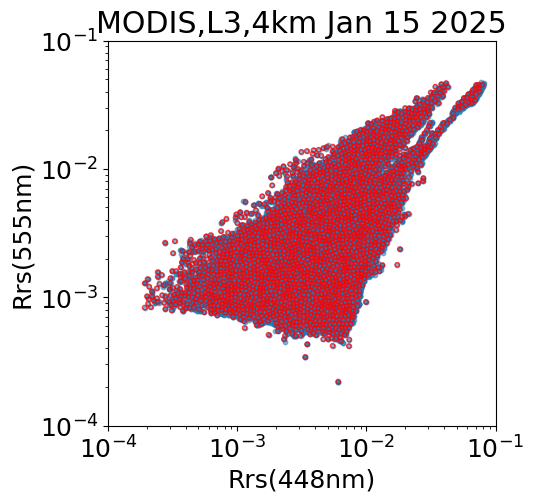

In [263]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(pace_pts[:,0],pace_pts[:,1],alpha=0.5, s=10)
plt.scatter(uniques[0],uniques[1],facecolor='none',edgecolor='r',alpha=0.75, s=10)

plt.xlim(0.0001,.1)
plt.ylim(0.0001,.1)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Rrs(448nm)')
plt.ylabel('Rrs(555nm)')

plt.title('MODIS,L3,4km Jan 15 2025')

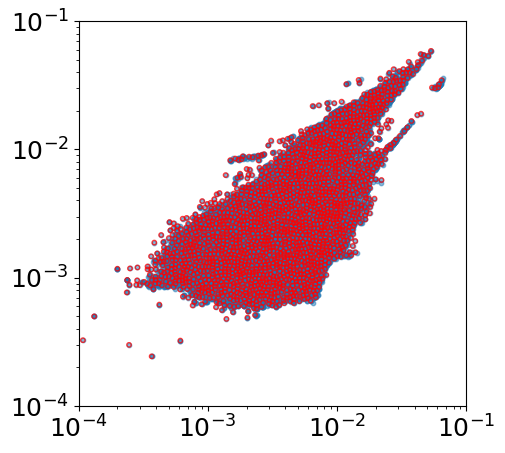

In [241]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(pace_pts[:,0],pace_pts[:,1],alpha=0.5, s=10)
plt.scatter(uniques[0],uniques[1],facecolor='none',edgecolor='r',alpha=0.75, s=10)

plt.xlim(0.0001,.1)
plt.ylim(0.0001,.1)

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Rrs(448nm)')
plt.ylabel('Rrs(555nm)')

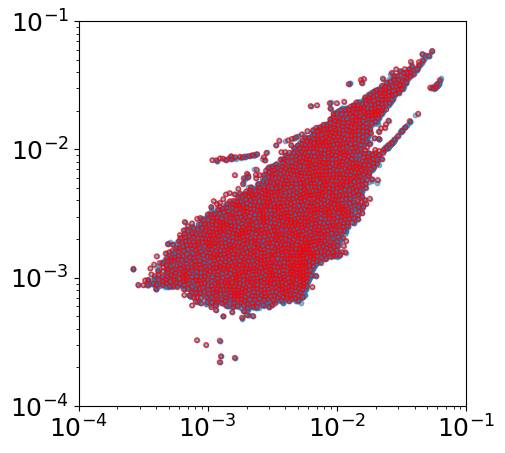

In [218]:
fig, ax = plt.subplots(figsize=(5,5))

plt.scatter(pace_pts[:,0],pace_pts[:,1],alpha=0.5, s=10)
plt.scatter(uniques[0],uniques[1],facecolor='none',edgecolor='r',alpha=0.75, s=10)

plt.xlim(0.0001,.1)
plt.ylim(0.0001,.1)

plt.xscale('log')
plt.yscale('log')

In [215]:
# 0p1deg unique over total nonnan for july 1st 2024 using MBR vs green
1781/1016560 * 100

0.17519870937278667

In [216]:
# 4km unique over total nonnan for july 1st 2024 using MBR vs green
2088/5853670 * 100

0.035669930146386794

In [214]:
# 4km unique over total nonnan for Jan 15th 2025 using MBR vs green
1968/6614508 * 100

0.029752779798588192

In [213]:
# 4km unique over total nonnan for Jan 15th 2025 using 488 vs 555
1800/6614508 * 100

0.027212908352367247

In [5]:
tspan = ("2024-07-01", "2024-07-01")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    temporal=tspan,
    # bounding_box=bbox,
    # cloud_cover=clouds,
)

In [6]:
paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/16 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/16 [00:00<?, ?it/s]

In [7]:
pace_fns = []
for i in range(len(paths)):
    print(paths[i])
    if '8D' in str(paths[i]):
        if '0p1deg' in str(paths[i]):
        # if '4km' in str(paths[i]):
            pace_fns.append(paths[i])
            print(i)

<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240601_20240702.L3m.R32.RRS.V3_1.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240601_20240702.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240609_20240710.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240609_20240710.L3m.R32.RRS.V3_1.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240617_20240718.L3m.R32.RRS.V3_1.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240617_20240718.L3m.R32.RRS.V3_1.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240621_20240920.L3m.SNSU.RRS.V3_1.Rrs.0p1deg.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240621_20240920.L3m.SNSU.RRS.V3_1.Rrs.4km.nc>
<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240625_20240702.L3m.8D.RRS.V3_1.

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240625_20240702.L3m.8D.RRS.V3_1.Rrs.0p1deg.nc>]

In [13]:
pace_fns

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20240625_20240702.L3m.8D.RRS.V3_1.Rrs.0p1deg.nc>]

In [19]:
results[8]

Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L3M_RRS'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'WestBoundingCoordinate': -180, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-07-02T23:59:59Z', 'BeginningDateTime': '2024-06-25T00:00:00Z'}}
Size(MB): 450.3872604370117
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240625_20240702.L3m.8D.RRS.V3_1.Rrs.0p1deg.nc']

In [20]:
paths = earthaccess.download(results[8], local_path="data")

In [21]:
paths

[PosixPath('data/PACE_OCI.20240625_20240702.L3m.8D.RRS.V3_1.Rrs.0p1deg.nc')]

In [22]:
pace_global = xr.open_mfdataset(paths)

In [24]:
pace_global.load()

<xarray.Dataset> Size: 4GB
Dimensions:     (wavelength: 172, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 4GB nan nan nan ... nan nan nan
    palette     (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 ... 0 0 0 0 0
Attributes: (12/64)
    product_name:                      PACE_OCI.20240625_20240702.L3m.8D.RRS....
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         2439051
    data_minimum:                      -0.009991999
    data_maximum:                      0.09496105

In [49]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

# this was the original distance approach in 2D
# x = np.nanmax([valente_df[442.1],valente_df[490.0]],axis=0)
# y = valente_df[551.1].values
# pts = np.array([x,y])
# pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# the 3D approach
pts = np.array([valente_df[442.1],valente_df[490.0],valente_df[551.1]])
pts = pts.T[(~np.isnan(pts)).all(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  # return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)
    return(np.linalg.norm(a-b))

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist = d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.3]

array([0.46070309, 1.03315803, 0.332577  , 0.37358102, 0.30020007,
       1.25590579, 3.02695745])

In [50]:
ds = pace_global

from scipy.spatial import Delaunay

native_ids = [] 
inside = []
outside = []
valid_pixel_count = []

count_map = np.zeros([1800,3600])
nonnan_map = np.zeros([1800,3600])

count_map_ndims = []
nonnan_map_ndims = []

hull =  Delaunay(pts[dist_ratio < 0.2])

# 2D
# pace_pts = np.array([np.max([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten()],axis=0),ds.Rrs[:,:,84].values.flatten()]).T

# 3D
pace_pts = np.array([ds.Rrs[:,:,42].values.flatten(),ds.Rrs[:,:,60].values.flatten(),ds.Rrs[:,:,84].values.flatten()]).T

# pace_pts = np.array([np.max([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), 
#                     modis_global.Rrs_555.values.flatten()]).T

print('data formatted')

bool_mask = (~np.isnan(pace_pts)).all(axis=1)

valid_pixel_count.append(np.count_nonzero(bool_mask))

points_in_hull = np.zeros(6480000, dtype=bool)
points_in_hull[bool_mask] = hull.find_simplex(pace_pts[bool_mask])>=0
print('hull analysis done')

# for PACE
count_map += points_in_hull.reshape(ds.Rrs.shape[:2])
count_map_ndims.append(points_in_hull.reshape(ds.Rrs.shape[:2]))
nonnan_map_ndims.append((~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2]))
nonnan_map += (~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs.shape[:2])

# for MODIS
# count_map += points_in_hull.reshape(ds.Rrs_443.shape[:2])
# count_map_ndims.append(points_in_hull.reshape(ds.Rrs_443.shape[:2]))
# nonnan_map_ndims.append((~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs_443.shape[:2]))
# nonnan_map += (~np.isnan(pace_pts)).all(axis=1).astype(int).reshape(ds.Rrs_443.shape[:2])

boolie, count = np.unique(points_in_hull[(~np.isnan(pace_pts)).all(axis=1)],return_counts=True)
if boolie[0]:
    in_count = count[0]
    out_count = count[1]
else:
    in_count = count[1]
    out_count = count[0]
inside.append(in_count)
outside.append(out_count)

data formatted
hull analysis done


In [51]:
1-np.nanmean((count_map/nonnan_map).flatten())

/tmp/ipykernel_108/784881.py:1: RuntimeWarning: invalid value encountered in divide
  1-np.nanmean((count_map/nonnan_map).flatten())


0.17933696343372896

In [52]:
nonnan_map.flatten().sum()

2439051.0

In [53]:
count_map.flatten().sum()

2001639.0

In [54]:
ds['count_map_normalized'] = (('lat', 'lon'), count_map/nonnan_map)

/tmp/ipykernel_108/1700129919.py:1: RuntimeWarning: invalid value encountered in divide
  ds['count_map_normalized'] = (('lat', 'lon'), count_map/nonnan_map)


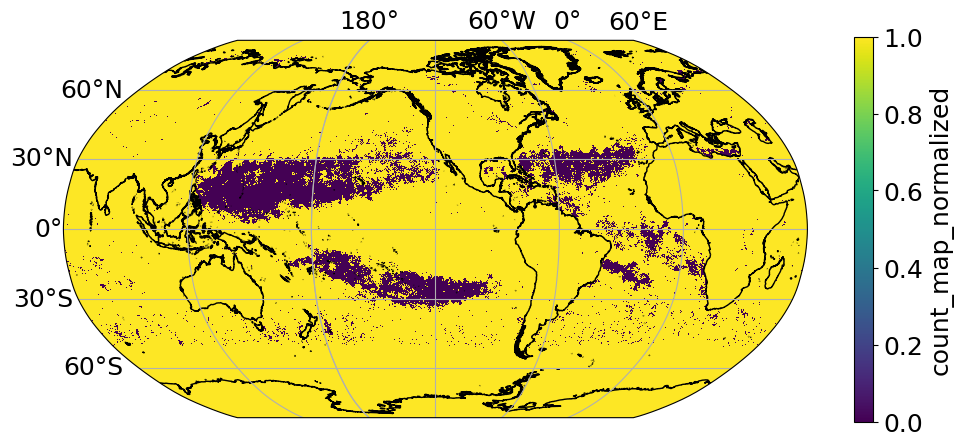

In [55]:
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson(central_longitude=-120)))
ax.coastlines(resolution='10m')
ds.count_map_normalized.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.0,vmax=1, transform=crs.PlateCarree())
gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)

# ax.set_xlim(-90,-20)
# ax.set_ylim(10,60)


# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

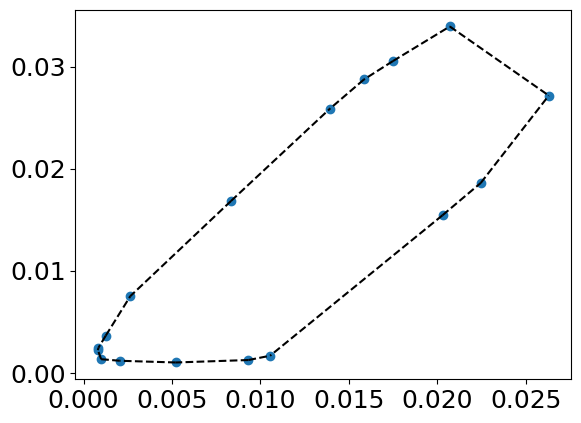

In [310]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    plt.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

plt.scatter(pts[dist_ratio < 0.2][hull.vertices][:,0],pts[dist_ratio < 0.2][hull.vertices][:,1])

In [62]:
?gpd.points_from_xy

Signature: gpd.points_from_xy(x, y, z=None, crs=None)
Docstring:
Generate GeometryArray of shapely Point geometries from x, y(, z) coordinates.

In case of geographic coordinates, it is assumed that longitude is captured by
``x`` coordinates and latitude by ``y``.

Parameters
----------
x, y, z : iterable
crs : value, optional
    Coordinate Reference System of the geometry objects. Can be anything accepted by
    :meth:`pyproj.CRS.from_user_input() <pyproj.crs.CRS.from_user_input>`,
    such as an authority string (eg "EPSG:4326") or a WKT string.

Examples
--------
>>> import pandas as pd
>>> df = pd.DataFrame({'x': [0, 1, 2], 'y': [0, 1, 2], 'z': [0, 1, 2]})
>>> df
   x  y  z
0  0  0  0
1  1  1  1
2  2  2  2
>>> geometry = geopandas.points_from_xy(x=[1, 0], y=[0, 1])
>>> geometry = geopandas.points_from_xy(df['x'], df['y'], df['z'])
>>> gdf = geopandas.GeoDataFrame(
...     df, geometry=geopandas.points_from_xy(df['x'], df['y']))

Having geographic coordinates:

>>> df = pd.DataFram

In [65]:
from scipy.spatial import ConvexHull

hull = ConvexHull(pts[dist_ratio < 0.2])

from shapely.geometry import Polygon, Point
import geopandas

hull_polygon = Polygon(pts[dist_ratio < 0.2][hull.vertices])
hull_geoseries = geopandas.GeoSeries(hull_polygon)

x = list(pace_pts[:,0])
y = list(pace_pts[:,1])
z = list(pace_pts[:,1])

pace_pts_geoseries = gpd.GeoSeries(gpd.points_from_xy(x, y, z))

dist = []
for pt in pace_pts_geoseries:
    dist.append(hull_geoseries.distance(pt).values[0])

In [66]:
ds['dist'] = (('lat', 'lon'), np.array(dist).reshape(1800,3600))

In [ ]:
# # crs is Robinson which I like for global maps
# fig, ax = plt.subplots(figsize=(25,8), subplot_kw=dict(projection=crs.Robinson(central_longitude=-120)))

# ax.coastlines(resolution='10m')
# gl = ax.gridlines(color='grey', linestyle='--', lw=0.1, draw_labels=True)

# # gl = ax.gridlines(color='grey', linestyle='--', lw=0.1, draw_labels=True)
# gl.bottom_labels=False   # suppress top labels
# gl.right_labels=False # suppress right labels

# robinson = crs.Robinson(central_longitude=-120).proj4_init
# gdf[::100].to_crs(robinson).plot(ax=ax,column='Chl_lineheight',legend=True, norm=matplotlib.colors.LogNorm(vmin=0.01, vmax=5), cmap='viridis',legend_kwds={'label': 'chla [mg/m3]'})

# # ax.set_title('chla [mg/m3]')

# plt.savefig('figures/chla_map.png',dpi=300, transparent=True)

# plt.show()

In [67]:
1

1

In [80]:
ds['nonnan'] = ds.dist == 0

In [81]:
np.unique(ds['nonnan'], return_counts=True)

(array([False,  True]), array([5385462, 1094538]))

In [71]:
ds['nonnan'] = ds['nonnan'].where(ds['nonnan'] == True, np.nan)

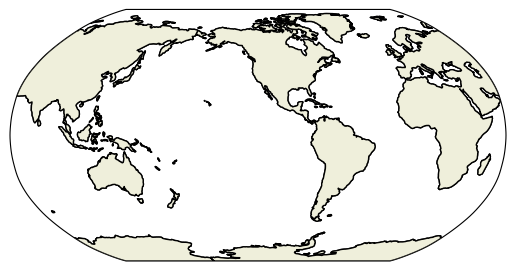

In [57]:
import cartopy as cart

ax = plt.axes(projection=crs.Robinson(central_longitude=-120))
ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')

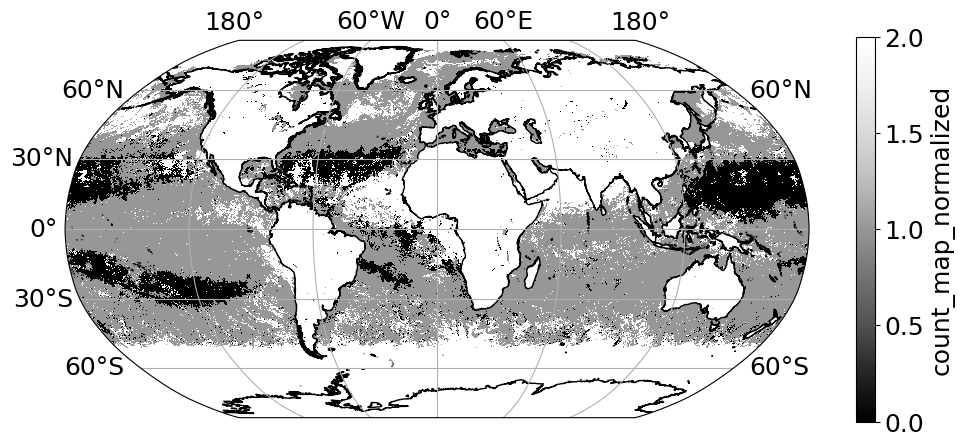

In [86]:
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
ds.count_map_normalized.plot(ax=ax, x='lon', y='lat',cmap='Greys_r', vmin=0,vmax=2, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# ax.set_xlim(115,180)
# ax.set_ylim(0,35)

plt.savefig('in_out_hull_pacific_full.png',dpi=300)

plt.show()

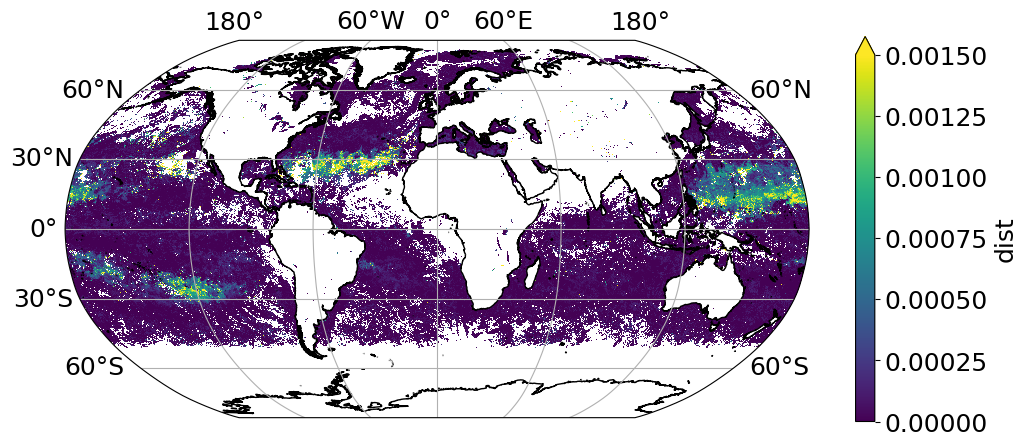

In [85]:
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
# ds.count_map_normalized.plot(ax=ax, x='lon', y='lat',cmap='Greys_r', vmin=0,vmax=2, transform=crs.PlateCarree())
ds.dist.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.0,vmax=.0015, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

# ax.set_xlim(115,180)
# ax.set_ylim(0,35)

plt.savefig('dist_hull_pacific_full.png',dpi=300)

plt.show()

In [76]:
np.unique(ds.count_map_normalized)

array([ 0.,  1., nan])

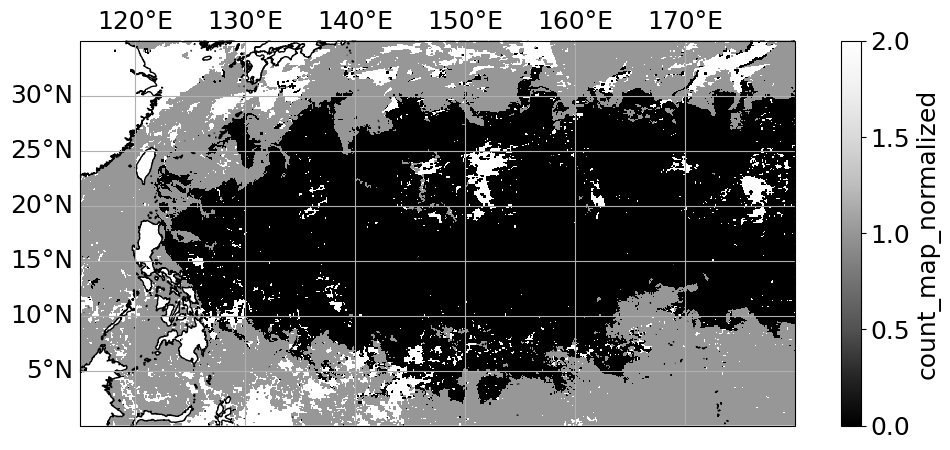

In [83]:
fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.PlateCarree()))
# fig, ax = plt.subplots(figsize=(12,5), subplot_kw=dict(projection=crs.Robinson(central_longitude=-120)))
ax.coastlines(resolution='10m')
ds.count_map_normalized.plot(ax=ax, x='lon', y='lat',cmap='Greys_r', vmin=0,vmax=2, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

ax.set_xlim(115,180)
ax.set_ylim(0,35)

plt.savefig('in_out_hull_pacific.png',dpi=300)

plt.show()

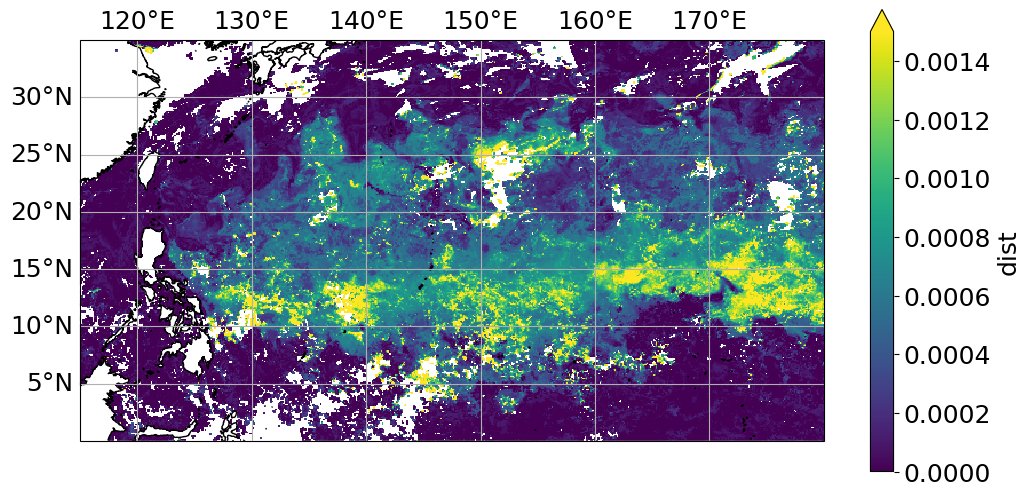

In [84]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))

ax.coastlines(resolution='10m')
ds.dist.plot(ax=ax, x='lon', y='lat', cmap='viridis', vmin=0.0,vmax=.0015, transform=crs.PlateCarree())

# ds['nonnan'].plot(ax=ax, x='lon', y='lat', cmap='Greys', transform=crs.PlateCarree(),add_colorbar=False)

gl = ax.gridlines(draw_labels=True)
gl.bottom_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels

ax.set_xlim(115,180)
ax.set_ylim(0,35)

plt.savefig('dist_to_hull_pacific.png',dpi=300)

plt.show()

(0.0, 35.0)

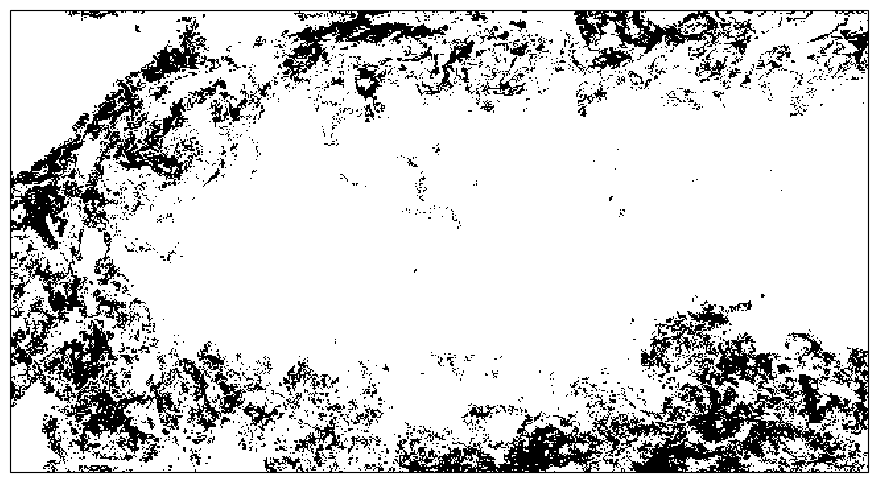

In [82]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ds['nonnan'].plot(ax=ax, x='lon', y='lat', cmap='Greys', transform=crs.PlateCarree(),add_colorbar=False)

ax.set_xlim(115,180)
ax.set_ylim(0,35)


# OLD STUFF

# Questions to Explore

1. how representative is this of the global MODIS dataset?

2. assess more realistic uncertainties especially where we don't span
    see to what degree for the same HPLC (within uncertainty - order +/- 30%) that reflectances change
    see how far off the manifold some things fall

3. is the algorithm better is we just do matchups with Rrs

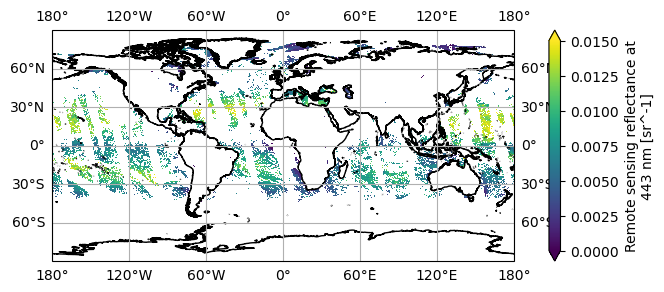

In [85]:
fig, ax = plt.subplots(figsize=(9,3), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

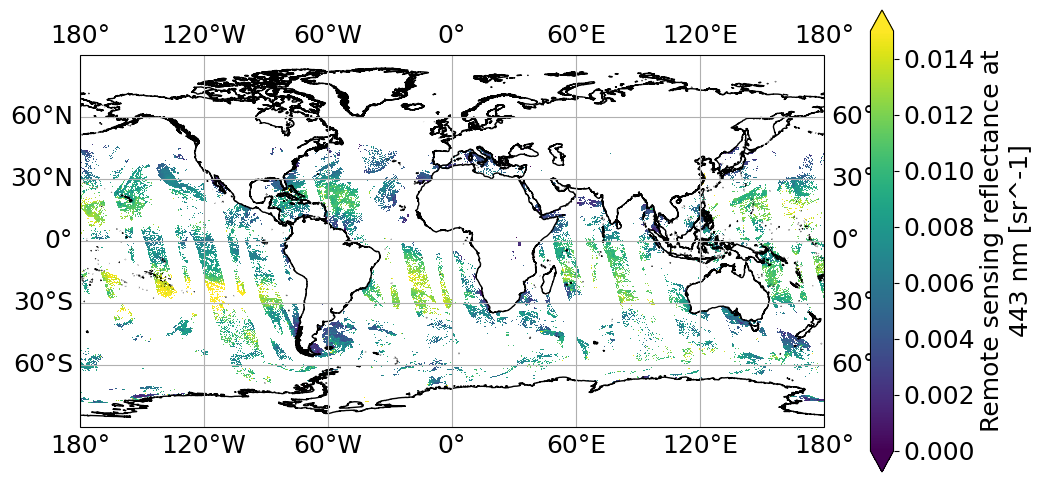

In [34]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

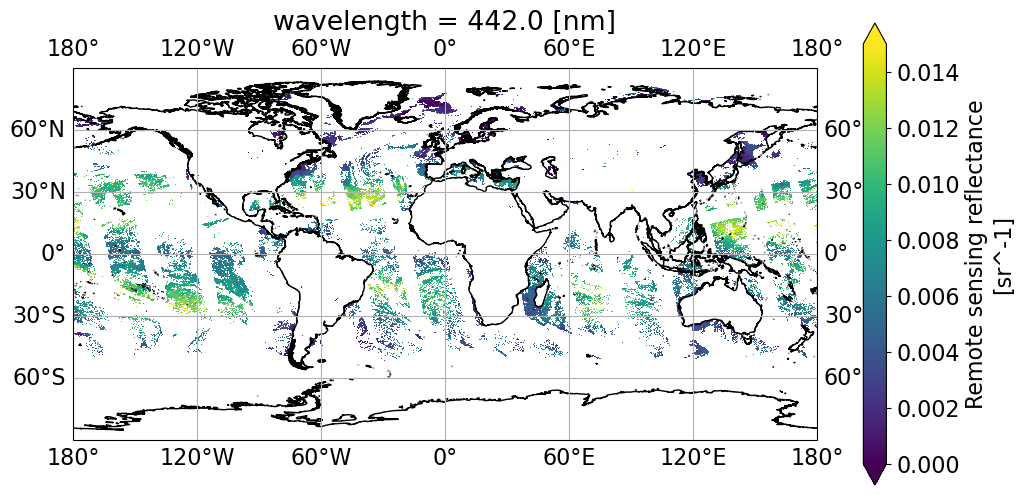

In [248]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

dataset.Rrs[:,:,42].plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='viridis')

gl = ax.gridlines(draw_labels=True)

# plt.savefig('figs/440nm_northwest_atlantic_pace.png',dpi=300)

plt.show()

/tmp/ipykernel_760/3567260172.py:3: RuntimeWarning: All-NaN axis encountered
  ax.hist(np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[555], label='Valente')
/tmp/ipykernel_760/3567260172.py:5: RuntimeWarning: All-NaN axis encountered
  ax.hist(np.nanmax([dataset_oc.Rrs_443.values.flatten()[::1500],


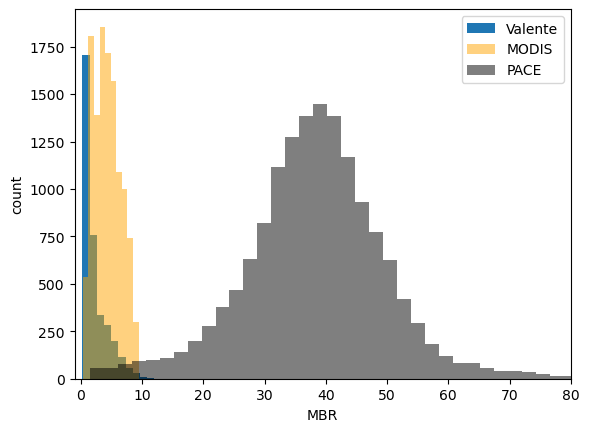

In [178]:
skip_num = 1
fig,ax= plt.subplots()
ax.hist(np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)/valente_reduced[555], label='Valente')

ax.hist(np.nanmax([dataset_oc.Rrs_443.values.flatten()[::1500],
                       dataset_oc.Rrs_488.values.flatten()[::1500]],axis=0)/dataset_oc.Rrs_555.values.flatten()[::1500],color='orange',alpha=0.5, label='MODIS')

ax.hist(np.nanmax([
    dataset.Rrs[:,:,42].values.flatten()[::skip_num],
    dataset.Rrs[:,:,60].values.flatten()[::skip_num]])/
         dataset.Rrs[:,:,87].values.flatten()[::skip_num],
         color='black',alpha=0.5, label='PACE',bins=45)

ax.legend(loc='upper right')
ax.set_xlabel('MBR')

ax.set_xlim(-1,80)

# ax.set_yscale('log')

ax.set_ylabel('count')

# plt.savefig('figs/MBR_comparison_modis_pace_valente.png',dpi=300)

plt.show()

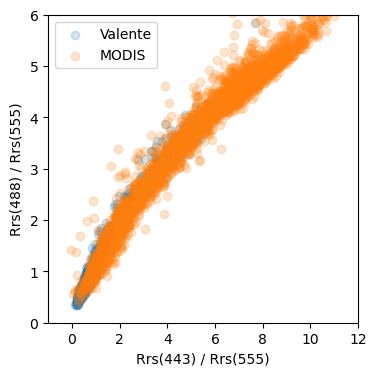

In [88]:
skip_num = 1000
# Rrs443/Rrs555 vs. Rrs490/Rrs555

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(valente_reduced[442.1]/valente_reduced[551.1], valente_reduced[490.0]/valente_reduced[551.1],alpha=0.2, label='Valente')

ax.scatter(modis_global.Rrs_443.values.flatten()[::skip_num]/modis_global.Rrs_555.values.flatten()[::skip_num], 
            modis_global.Rrs_488.values.flatten()[::skip_num]/modis_global.Rrs_555.values.flatten()[::skip_num],alpha=0.2, label='MODIS')

ax.set_xlabel('Rrs(443) / Rrs(555)')
ax.set_ylabel('Rrs(488) / Rrs(555)')

ax.legend()

ax.set_xlim(-1,12)
ax.set_ylim(0,6)

# plt.savefig('figs/phase_comparison_modis_valente.png',dpi=300)


plt.show()

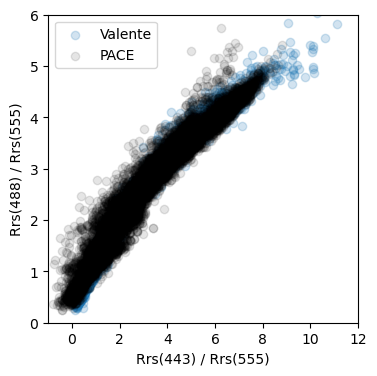

In [131]:
# Rrs443/Rrs555 vs. Rrs490/Rrs555

fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(valente_reduced[442.1]/valente_reduced[555], valente_reduced[490.0]/valente_reduced[555],alpha=0.2,label='Valente')

ax.scatter(dataset.Rrs[:,:,42].values.flatten()[::skip_num]/dataset.Rrs[:,:,84].values.flatten()[::skip_num], 
            dataset.Rrs[:,:,60].values.flatten()[::skip_num]/dataset.Rrs[:,:,84].values.flatten()[::skip_num],alpha=0.1, label='PACE',c='black')

ax.set_xlabel('Rrs(443) / Rrs(555)')
ax.set_ylabel('Rrs(488) / Rrs(555)')

ax.set_xlim(-1,12)
ax.set_ylim(0,6)

ax.legend()

plt.savefig('figs/phase_comparison_pace_valente.png',dpi=300)

plt.show()

In [63]:
# Comparing the Rrs in green and blue

In [35]:
modis_global

<xarray.Dataset> Size: 1GB
Dimensions:  (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    palette  (rgb, eightbitcolor) int8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
    Rrs_412  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_443  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_469  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_488  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_531  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_547  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_555  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_645  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_667  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
    Rrs_678  (lat, lon) float32 149MB dask.array<chunksize=(4320, 8640), meta=np.ndarray>
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20200101.L3m.DAY.RRS.Rrs_412...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        Attribute elided: Unsupported attribute...
    data_minimum:                     -0.0034379999
    data_maximum:                     0.06296955

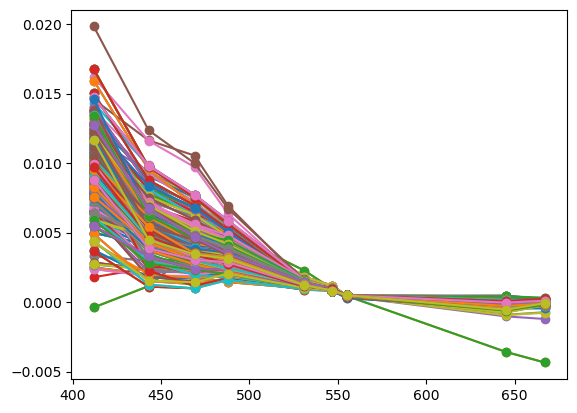

In [118]:
plt.plot([412, 443, 469, 488, 531, 547, 555,645, 667],np.array([modis_global.Rrs_412.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_443.values[modis_global.Rrs_555.values < 0.0005], 
                                 modis_global.Rrs_469.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_488.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_531.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_547.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_555.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_645.values[modis_global.Rrs_555.values < 0.0005],
                                 modis_global.Rrs_667.values[modis_global.Rrs_555.values < 0.0005]]),
         marker='o')
plt.show()

In [37]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0
    
x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)
y = valente_reduced[551.1].values

pts = np.array([x,y])
pts = pts.T[~np.isnan(pts).any(axis=0)]

# go through the points, if they don't have a neighbor within 30% of their value then throw them out, then make a convex hull

import math
def get_dist(a,b):
  return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

np_list = []
for i in range(len(pts)):
    dist = math.inf #(infinity)
    npidx = 0
    for j in range(len(pts)):
       d = get_dist(pts[i],pts[j])
       if d<dist and d!=0: # to avoid the same point
          dist =d
          npidx = j
    np_list.append(dist)

mean_val = pts.mean(axis=1)

dist_ratio = np_list/mean_val
dist_ratio[dist_ratio > 0.3]

/tmp/ipykernel_125/2944198737.py:16: RuntimeWarning: All-NaN axis encountered
  x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0)


array([0.31491375, 0.81345096, 1.28377256, 3.48624781])

/tmp/ipykernel_125/752308539.py:15: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


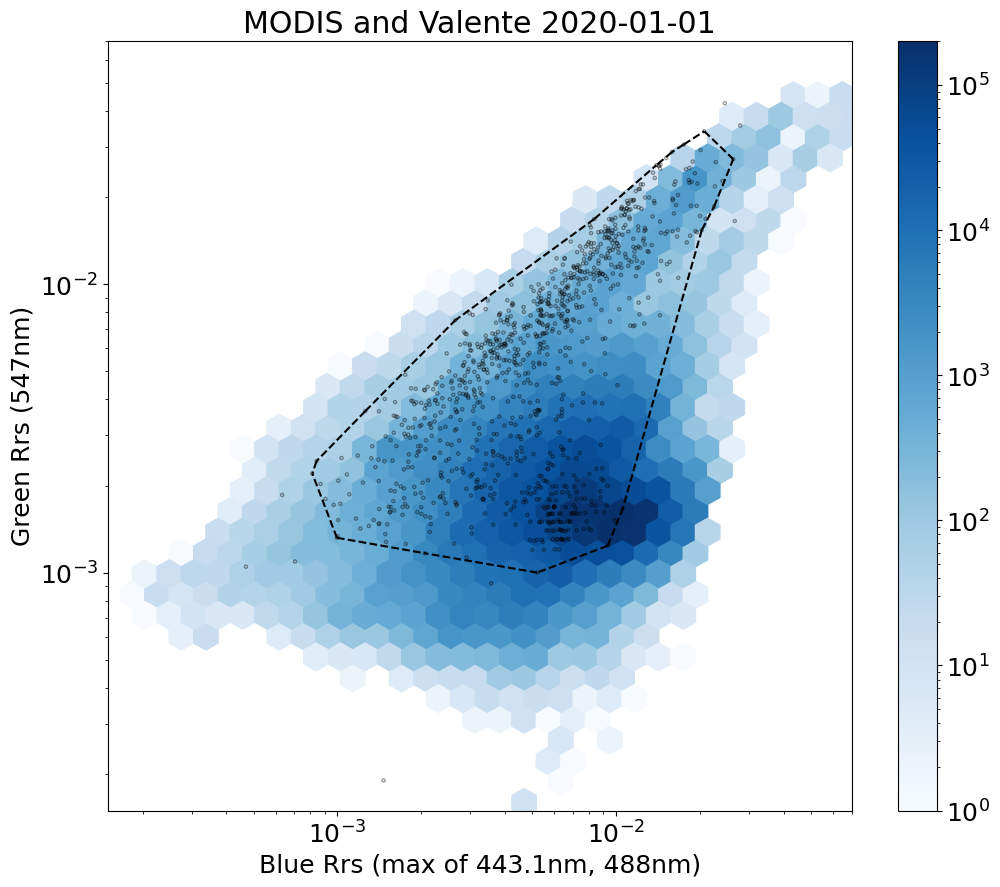

In [40]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
                       modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
           y = modis_global.Rrs_555.values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente 2020-01-01')

plt.savefig('figs/modis_winter_valente_density.png',dpi=600)

plt.show()

/tmp/ipykernel_125/114002327.py:15: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


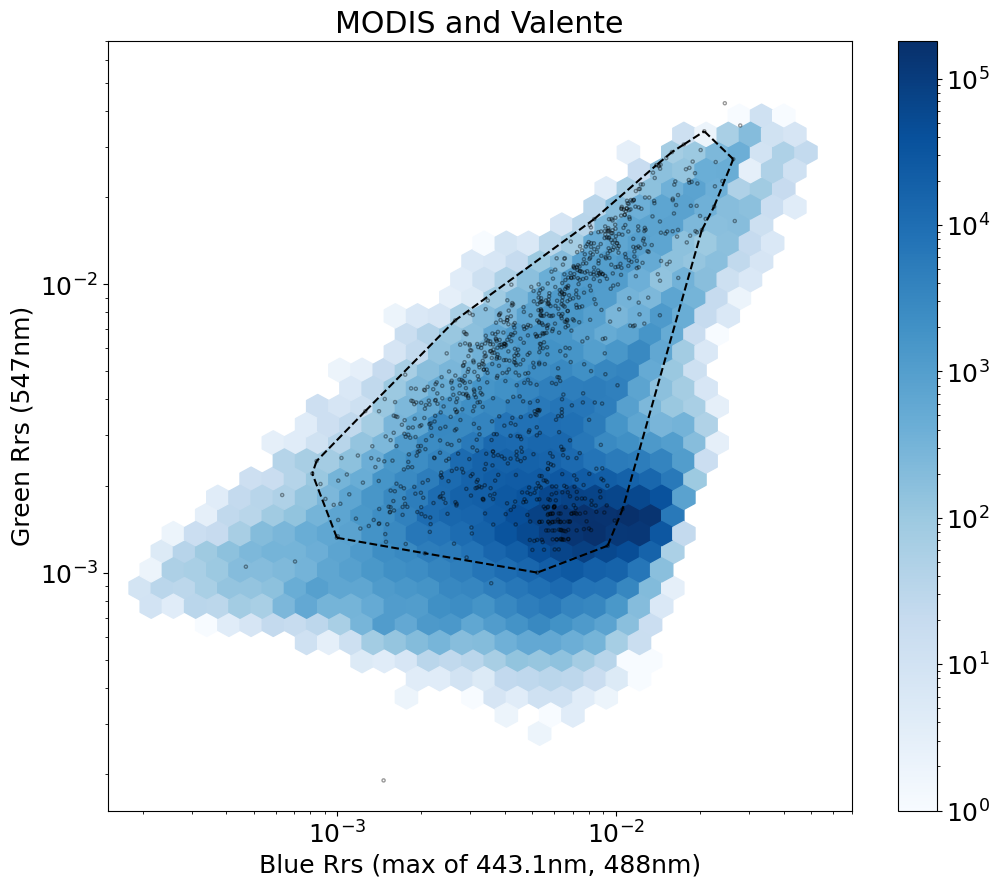

In [274]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([modis_global.Rrs_443.values.flatten()[::skip_num],
                       modis_global.Rrs_488.values.flatten()[::skip_num]],axis=0), 
           y = modis_global.Rrs_555.values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente')

plt.savefig('figs/modis_summer_valente_density.png',dpi=600)

plt.show()

Build the MODIS points to compare

In [275]:
modis_pts = np.array([np.nanmax([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), modis_global.Rrs_555.values.flatten()]).T
points_in_hull = in_hull(modis_pts,pts[dist_ratio < 0.2])

/tmp/ipykernel_125/1844822763.py:1: RuntimeWarning: All-NaN axis encountered
  modis_pts = np.array([np.nanmax([modis_global.Rrs_443.values.flatten(),modis_global.Rrs_488.values.flatten()],axis=0), modis_global.Rrs_555.values.flatten()]).T


In [276]:
points_in_hull = points_in_hull.astype(np.float16)

In [277]:
points_in_hull[np.isnan(modis_pts[:,0])] = np.nan

In [278]:
np.unique(points_in_hull, return_counts=True)

(array([ 0.,  1., nan], dtype=float16), array([ 1081636,  2468198, 33774966]))

In [183]:
np.unique(points_in_hull, return_counts=True)

(array([ 0.,  1., nan], dtype=float16), array([ 1037361,  2287763, 33999676]))

In [180]:
modis_global["in_hull"]=(['lat', 'lon'],  clusters.reshape(4320,8640))

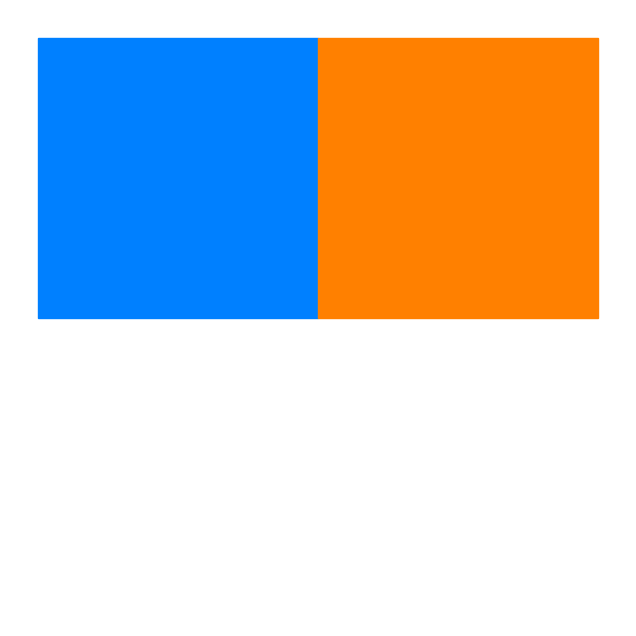

In [181]:
import distinctipy
N=2
colours = distinctipy.get_colors(N, colorblind_type='Deuteranomaly',rng=30)

distinctipy.color_swatch(colours)

distincti_cmap_bi = distinctipy.get_colormap(colours)

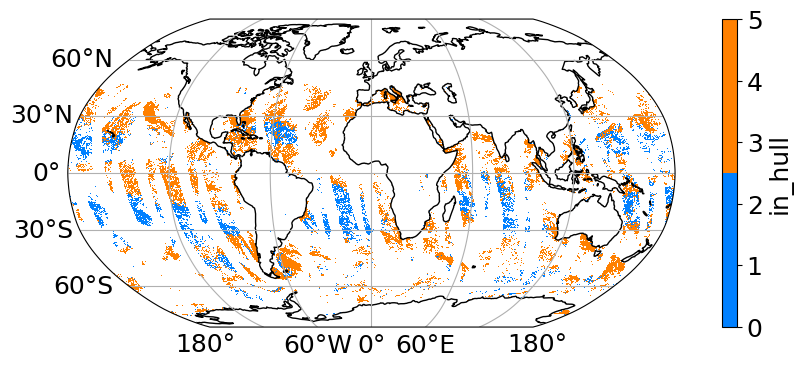

In [184]:
fig, ax = plt.subplots(figsize=(12,4), subplot_kw=dict(projection=crs.Robinson()))

ax.coastlines()
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.in_hull.plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap_bi, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)

gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_winter_outside_insitu_hull.png',dpi=300)

plt.show()

In [32]:
pace_global

<xarray.Dataset> Size: 5GB
Dimensions:     (wavelength: 184, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 5GB dask.array<chunksize=(16, 1024, 8), meta=np.ndarray>
    palette     (rgb, eightbitcolor) uint8 768B dask.array<chunksize=(3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/2.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         748293
    data_minimum:                      -0.010000003
    data_maximum:                      0.10000001

In [32]:
pace_global.load()

<xarray.Dataset> Size: 5GB
Dimensions:     (wavelength: 184, lat: 1800, lon: 3600, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 1kB 339.0 341.0 344.0 ... 714.0 717.0 719.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 5GB nan nan nan ... nan nan nan
    palette     (rgb, eightbitcolor) uint8 768B 147 0 108 144 0 ... 0 0 0 0 0
Attributes: (12/64)
    product_name:                      PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/2.0
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         748293
    data_minimum:                      -0.010000003
    data_maximum:                      0.10000001

<timed exec>:15: RuntimeWarning: All-NaN axis encountered


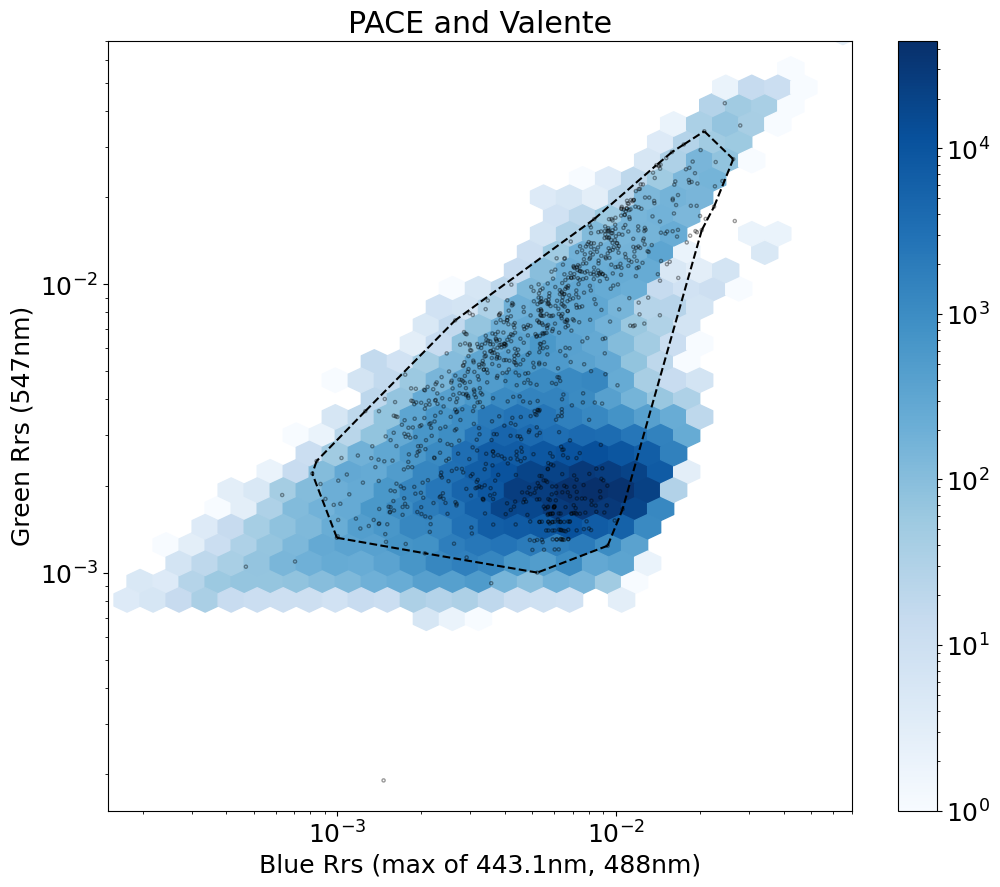

CPU times: user 3.57 s, sys: 143 ms, total: 3.71 s
Wall time: 3.8 s


In [39]:
%%time
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

hb = ax.hexbin(x = np.max([pace_global.Rrs[:,:,42].values.flatten()[::skip_num],
                       pace_global.Rrs[:,:,60].values.flatten()[::skip_num]],axis=0), 
           y = pace_global.Rrs[:,:,84].values.flatten()[::skip_num],
          yscale='log',xscale='log',
         gridsize=30,
          bins='log',
         cmap='Blues')

fig.colorbar(hb)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

ax.set_ylim(0.00015,0.07)
ax.set_xlim(0.00015,0.07)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')


# ax.set_xscale('log')
# ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('PACE and Valente')

plt.savefig('figs/pace_valente_density.png',dpi=600)

plt.show()

In [40]:
pace_pts = np.array([np.max([pace_global.Rrs[:,:,42].values.flatten(),pace_global.Rrs[:,:,60].values.flatten()],axis=0),pace_global.Rrs[:,:,84].values.flatten()]).T

In [41]:
pace_pts[::1000].shape

(6480, 2)

In [44]:
points_in_hull = in_hull(pace_pts[::1],pts[dist_ratio < 0.2])

In [53]:
np.unique(points_in_hull, return_counts=True)

(array([False,  True]), array([5841029,  638971]))

In [46]:
pace_global.Rrs[:,:,42]

<xarray.DataArray 'Rrs' (lat: 1800, lon: 3600)> Size: 26MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    wavelength  float64 8B 442.0
  * lat         (lat) float32 7kB 89.95 89.85 89.75 ... -89.75 -89.85 -89.95
  * lon         (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0
Attributes:
    long_name:      Remote sensing reflectance
    units:          sr^-1
    standard_name:  surface_ratio_of_upwelling_radiance_emerging_from_sea_wat...
    valid_min:      -30000
    valid_max:      25000
    display_scale:  linear
    display_min:    0.0
    display_max:    0.025

In [54]:
pace_pts.shape

(6480000, 2)

In [62]:
points_in_hull[np.isnan(pace_pts[:,0])] = pace_pts[:,0][np.isnan(pace_pts[:,0])]

In [94]:
points_in_hull = points_in_hull.astype(np.int8)

In [88]:
points_in_hull[np.isnan(pace_pts[:,0])] = -1

In [89]:
np.unique(points_in_hull,return_counts=True)

(array([-1.,  0.,  1.], dtype=float16), array([5731707,  109322,  638971]))

In [95]:
pace_global["in_hull"]=(['lat', 'lon'],  points_in_hull.reshape(1800,3600))

In [96]:
pace_global["in_hull"]

<xarray.DataArray 'in_hull' (lat: 1800, lon: 3600)> Size: 6MB
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)
Coordinates:
  * lat      (lat) float32 7kB 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.9 180.0

In [178]:
fig, ax = plt.subplots(figsize=(16,5), subplot_kw=dict(projection=crs.Robinson()))

ax.coastlines()
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

pace_global["in_hull"].plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap_bi, transform=crs.PlateCarree())
# modis_subset.Rrs_443.plot(ax=ax, x='lon', y='lat', vmin=0.00,vmax=0.015, cmap='Reds', transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False


plt.savefig('figs/pace_outside_insitu_hull.png',dpi=300)

plt.show()

In [97]:
pace_global.to_netcdf('data/pace_with_hull.nc')

### Cluster the MODIS data based on just blue and green

In [59]:
from sklearn.cluster import KMeans

In [60]:
1

1

In [203]:
modis_pts.shape

(37324800, 2)

In [62]:
modis_pts[~np.isnan(modis_pts).any(axis=1)].shape

(3325124, 2)

In [ ]:
0.002, 0.002

In [166]:
clusters = np.zeros(modis_pts.shape[0])

In [167]:
clusters[modis_pts[:,1] < 0.004] = 5
clusters[modis_pts[:,1] < 0.001] = 4
clusters[(modis_pts[:,0] > 0.01) & (modis_pts[:,1] < 0.008)] = 2
clusters[(modis_pts[:,0] > 0.01) & (modis_pts[:,1] < 0.002)] = 1
clusters[(modis_pts[:,0] < 0.002) & (modis_pts[:,1] < 0.004)] = 3

In [168]:
clusters[np.isnan(modis_pts).any(axis=1)] = np.nan

In [169]:
np.unique(clusters,return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5., nan]),
 array([   63324,   772918,   152546,    30585,   110364,  2195387,
        33999676]))

In [170]:
! pip install distinctipy

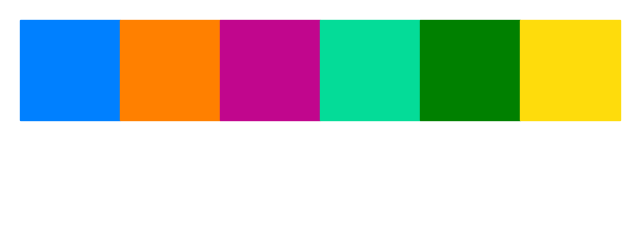

In [171]:
import distinctipy
N=6
colours = distinctipy.get_colors(N, colorblind_type='Deuteranomaly',rng=30)

distinctipy.color_swatch(colours)

distincti_cmap = distinctipy.get_colormap(colours)

In [172]:
1

1

/tmp/ipykernel_125/4147534972.py:9: RuntimeWarning: All-NaN axis encountered
  ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),


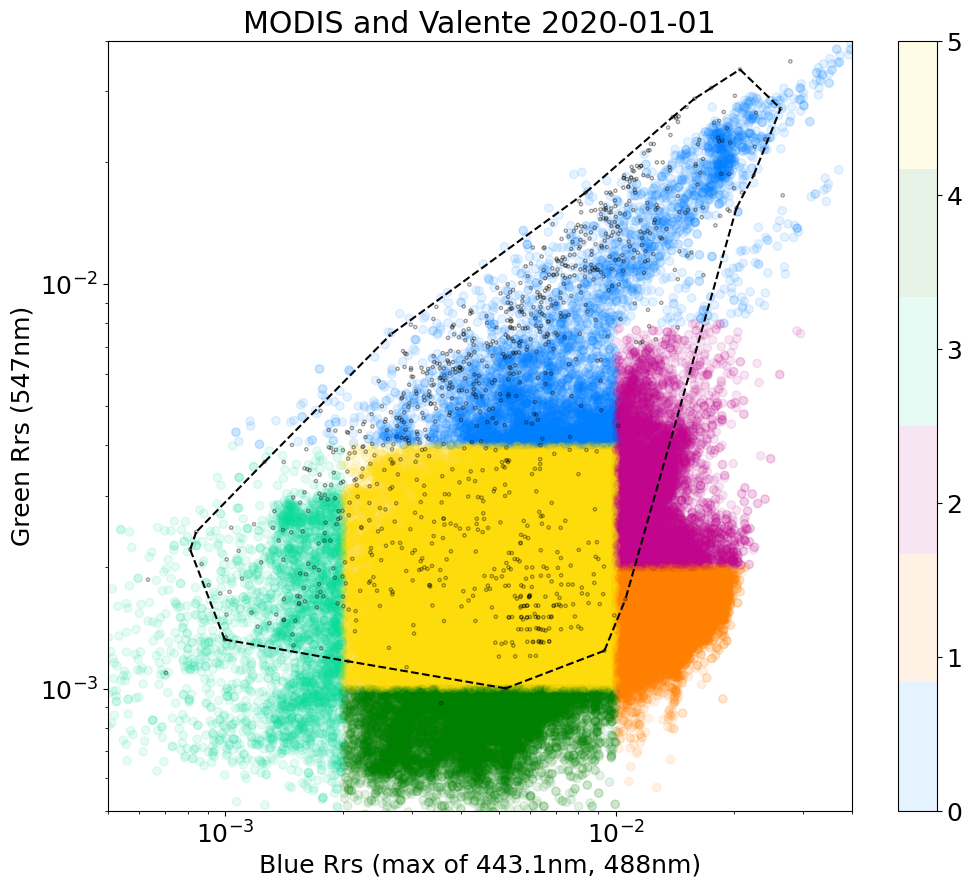

In [179]:
skip_num = 1

fig, ax = plt.subplots(figsize=(12,10))

cm = ax.scatter(modis_pts[::10,0],modis_pts[::10,1],c=clusters[::10],alpha=0.1, cmap=distincti_cmap)

fig.colorbar(cm)

ax.scatter(x = np.nanmax([valente_reduced[442.1],valente_reduced[490.0]],axis=0),
           y = valente_reduced[551.1], facecolor='none', edgecolor='k', alpha=0.4, label='Valente',s=5)

from scipy.spatial import ConvexHull, convex_hull_plot_2d

hull = ConvexHull(pts[dist_ratio < 0.2])

for simplex in hull.simplices:
    ax.plot(pts[dist_ratio < 0.2][simplex, 0], pts[dist_ratio < 0.2][simplex, 1], 'k--')

# ax.scatter(x=pts[:,0],y=pts[:,1])
# ax.scatter(x=pts[:,0][dist_ratio > 0.2],y=pts[:,1][dist_ratio > 0.2])

ax.set_ylim(0.0005,0.04)
ax.set_xlim(0.0005,0.04)


ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Blue Rrs (max of 443.1nm, 488nm)')
ax.set_ylabel('Green Rrs (547nm)')

ax.set_title('MODIS and Valente 2020-01-01')

plt.savefig('figs/modis_clusters.png',dpi=600)

plt.show()

In [174]:
modis_global["cluster"]=(['lat', 'lon'],  clusters.reshape(4320,8640))

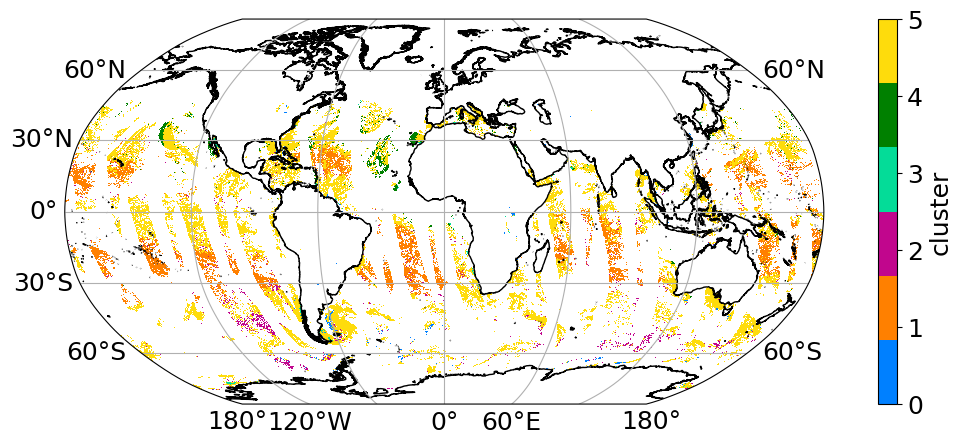

In [175]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.cluster.plot(ax=ax, x='lon', y='lat', cmap=distincti_cmap, transform=crs.PlateCarree())

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_clusters_from_undersampling.png',dpi=600)

plt.show()

### Calculate the min distance to the nearest in situ point

In [228]:
len(modis_pts) / 1e6

37.3248

In [229]:
from scipy.spatial import distance_matrix

In [248]:
dist_mat = distance_matrix(modis_pts_subset,pts_subset)

In [250]:
np.min(dist_mat,axis=0)

array([3.24634098e-04, 4.80097740e-05, 2.16014577e-05, ...,
       1.55069747e-05, 3.69956670e-06, 1.07911278e-04])

In [234]:
modis_pts_subset = modis_pts[~np.isnan(modis_pts).any(axis=1)]
pts_subset = pts[dist_ratio < 0.2]

In [268]:
dist_ratio.shape

(1024,)

In [267]:
pts_subset.shape

(1014, 2)

In [251]:
min_dists = []
for i in range(len(modis_pts_subset)):
    min_dists.append(np.min(np.linalg.norm(modis_pts_subset[i]-pts_subset,axis=1)))

IndexError: index 3325124 is out of bounds for axis 0 with size 3325124

In [252]:
i

3325124

In [253]:
min_dists = np.array(min_dists)

In [261]:
min(min_dists)

7.416244056223401e-08

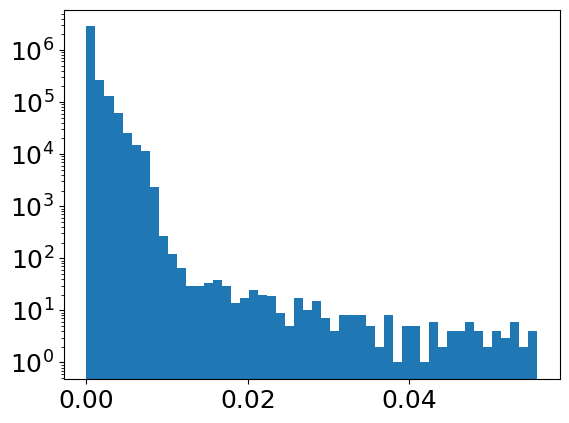

In [256]:
plt.hist(min_dists, bins=50)
plt.yscale('log')
plt.show()

In [257]:
modis_min_dists = np.zeros(modis_pts.shape[0])
modis_min_dists[np.isnan(modis_pts).any(axis=1)] = np.nan
modis_min_dists[~np.isnan(modis_pts).any(axis=1)] = min_dists

In [258]:
modis_global["min_dists"]=(['lat', 'lon'],  modis_min_dists.reshape(4320,8640))

In [260]:
import matplotlib

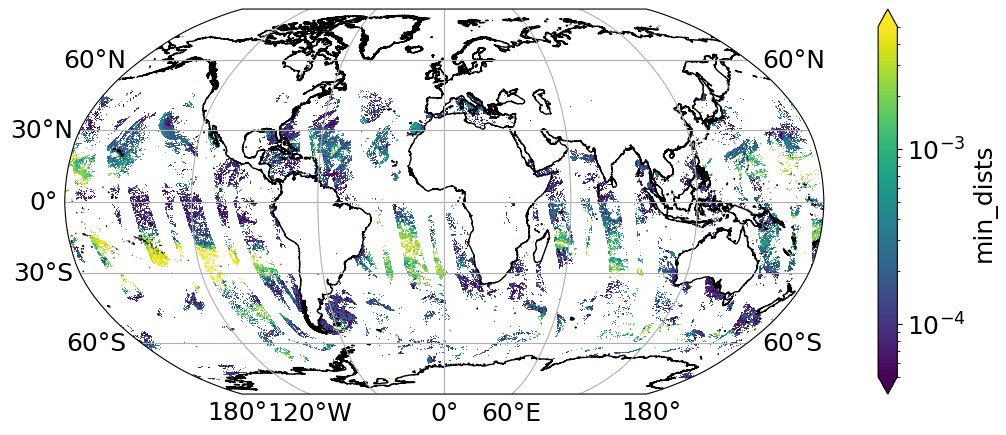

In [265]:
fig, ax = plt.subplots(figsize=(14,5), subplot_kw=dict(projection=crs.Robinson()))
ax.coastlines(resolution='10m')
# ax.set_ylim(34,45)
# ax.set_xlim(-80,-60)

modis_global.min_dists.plot(ax=ax, x='lon', y='lat', cmap='viridis', transform=crs.PlateCarree(), norm=matplotlib.colors.LogNorm(vmin=0.00005, vmax=0.005))

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

plt.savefig('figs/modis_min_dists.png',dpi=600)

plt.show()